# EPICS4 PV access example

Outside of this Jupyter notebook
- start the GUI, which will start the P4P server
```bash
$ python scripts/devGui.py --ip <RFSOC_IP_ADDDRESS>
```

In [1]:
# setup the P4P client
# https://mdavidsaver.github.io/p4p/client.html#usage
import numpy as np
import time
import matplotlib.pyplot as plt
from p4p.client.thread import Context
print( Context.providers() )
ctxt = Context('pva')

# Some useful pointers to reduce string lengths
Root = 'kek_bpm_rfsoc_demo_ioc:Root'
AxiVersion  = f'{Root}:RFSoC:AxiSocCore:AxiVersion'
ReadoutCtrl = f'{Root}:RFSoC:Application:ReadoutCtrl'
AdcDispProcessor  = [ f'{Root}:AdcDispProcessor[{i}]'  for i in range(4)]
AmpDispProcessor  = [ f'{Root}:AmpDispProcessor[{i}]'  for i in range(4)]
AdcFaultProcessor = [ f'{Root}:AdcFaultProcessor[{i}]' for i in range(4)]
AmpFaultProcessor = [ f'{Root}:AmpFaultProcessor[{i}]' for i in range(4)]

['pva']


In [2]:
# Function to trigger the waveform ring buffers
def TrigRingBuffer(trigType='liveDisplay'):

    if trigType=='liveDisplay':
        for i in range(4):
            ctxt.put(  f'{AdcDispProcessor[i]}:RxEnable', 1)
            ctxt.put(  f'{AmpDispProcessor[i]}:RxEnable', 1)             
            ctxt.put(  f'{AdcDispProcessor[i]}:Updated', 0)
            ctxt.put(  f'{AmpDispProcessor[i]}:Updated', 0)        
        ctxt.put( f'{ReadoutCtrl}:LiveDispTrigRaw', 1)
        #ctxt.rpc( f'{ReadoutCtrl}:LiveDispTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AdcDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)
            while ( ctxt.get( f'{AmpDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)                
    
    elif trigType=='faultDisplay':
        for i in range(4):
            ctxt.put(  f'{AdcFaultProcessor[i]}:RxEnable', 1)
            ctxt.put(  f'{AmpFaultProcessor[i]}:RxEnable', 1)               
            ctxt.put(  f'{AdcFaultProcessor[i]}:Updated', 0)
            ctxt.put(  f'{AmpFaultProcessor[i]}:Updated', 0)         
        ctxt.put( f'{ReadoutCtrl}:SwFaultTrigRaw', 1)
        # ctxt.rpc( f'{ReadoutCtrl}:SwFaultTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AdcFaultProcessor[i]}:Updated') != True):
                time.sleep(0.01)
            while ( ctxt.get( f'{AmpFaultProcessor[i]}:Updated') != True):
                time.sleep(0.01)  
    
    else:
        print('Error: TrigRingBuffer.trigType={trigType} is not supported')

# Function to plot the ADC/DAC waveforms
def PlotWavform(plotType='liveDisplay',dataType='Amp',ch=0,xMin=0,xMax=20):

    if plotType=='liveDisplay':
        if dataType=='Adc':
            xData = ctxt.get(f'{AdcDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AdcDispProcessor[ch]}:WaveformData')
        else:
            xData = ctxt.get(f'{AmpDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AmpDispProcessor[ch]}:WaveformData')               
    
    elif plotType=='faultDisplay':
        if dataType=='Adc':
            xData = ctxt.get(f'{AdcFaultProcessor[ch]}:Time')
            yData = ctxt.get(f'{AdcFaultProcessor[ch]}:WaveformData')
        else:
            xData = ctxt.get(f'{AmpFaultProcessor[ch]}:Time')
            yData = ctxt.get(f'{AmpFaultProcessor[ch]}:WaveformData')            
    else:
        print('Error: PlotWavform.plotType={trigType} is not supported')

    plt.plot(xData,yData)
    plt.xlim(xMin,xMax)
    plt.xlabel( 'Time (ns)' )
    plt.ylabel( f'{dataType}[ch={ch}] (Counts)' )
    plt.show()

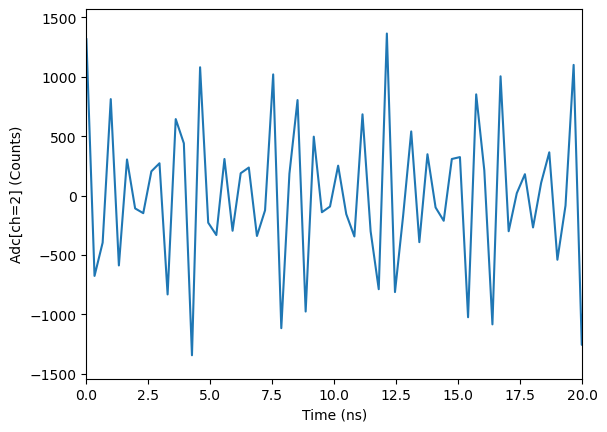

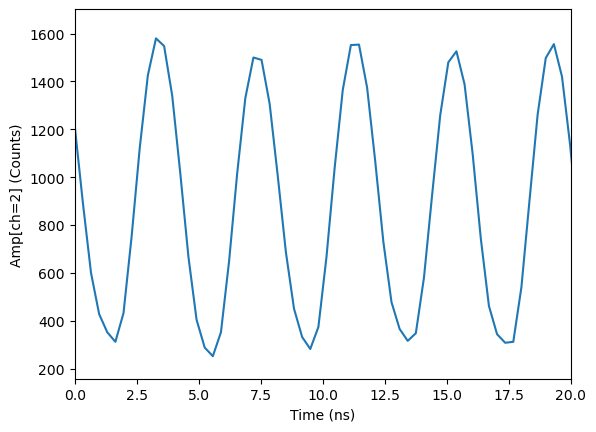

In [3]:
# Trigger the Live display
TrigRingBuffer(trigType='liveDisplay')

# Plot ADC[CH=2]
PlotWavform(plotType='liveDisplay',dataType='Adc',ch=2,xMin=0,xMax=20)

# Plot AMP[CH=2]
PlotWavform(plotType='liveDisplay',dataType='Amp',ch=2,xMin=0,xMax=20)

In [4]:
# Trigger the Fault display
TrigRingBuffer(trigType='faultDisplay')

# Plot ADC[CH=2] for 20 us
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20.0E+3)

# Plot ADC[CH=2] for 20 ns
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20)

TimeoutError: 

In [17]:
TrigRingBuffer(trigType='liveDisplay')

Data=[]
t=[]
t.append(ctxt.get(f'{AmpDispProcessor[0]}:Time'))
t.append(ctxt.get(f'{AmpDispProcessor[1]}:Time'))
t.append(ctxt.get(f'{AmpDispProcessor[2]}:Time'))
t.append(ctxt.get(f'{AmpDispProcessor[3]}:Time'))
Data.append(ctxt.get(f'{AmpDispProcessor[0]}:WaveformData'))
Data.append(ctxt.get(f'{AmpDispProcessor[1]}:WaveformData'))
Data.append(ctxt.get(f'{AmpDispProcessor[2]}:WaveformData'))
Data.append(ctxt.get(f'{AmpDispProcessor[3]}:WaveformData'))

In [18]:
start_index=np.argmin(Data[0][:12])
points_per_bunch=12
point=np.arange(0,len(Data[0]))
tate=[]
for i in range(start_index, len(Data[0])-points_per_bunch+start_index, points_per_bunch):
    tate.append(t[0][i])

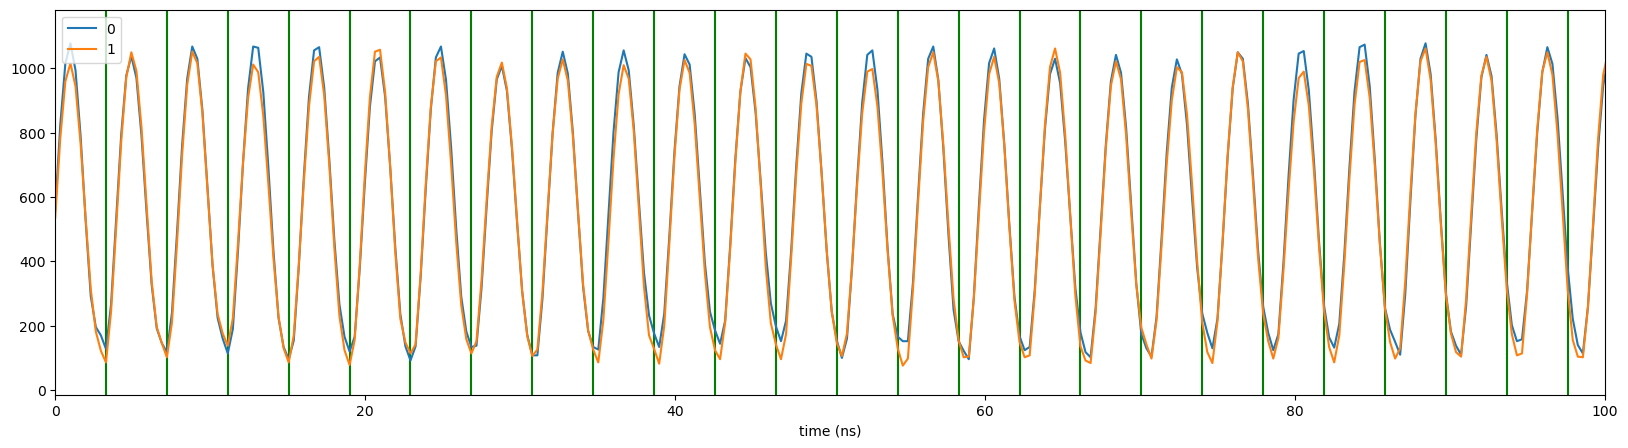

In [19]:
plt.figure(figsize=(20,5))
for x_value in tate:
    plt.axvline(x=x_value,c='g')
plt.plot(t[0],Data[0],label='0')
plt.plot(t[1],Data[1],label='1')
#plt.plot(point,Data[2],label='2')
#plt.plot(point,Data[3],label='3')
plt.xlim(0,100)
plt.xlabel("time (ns)")
plt.legend()
plt.show()

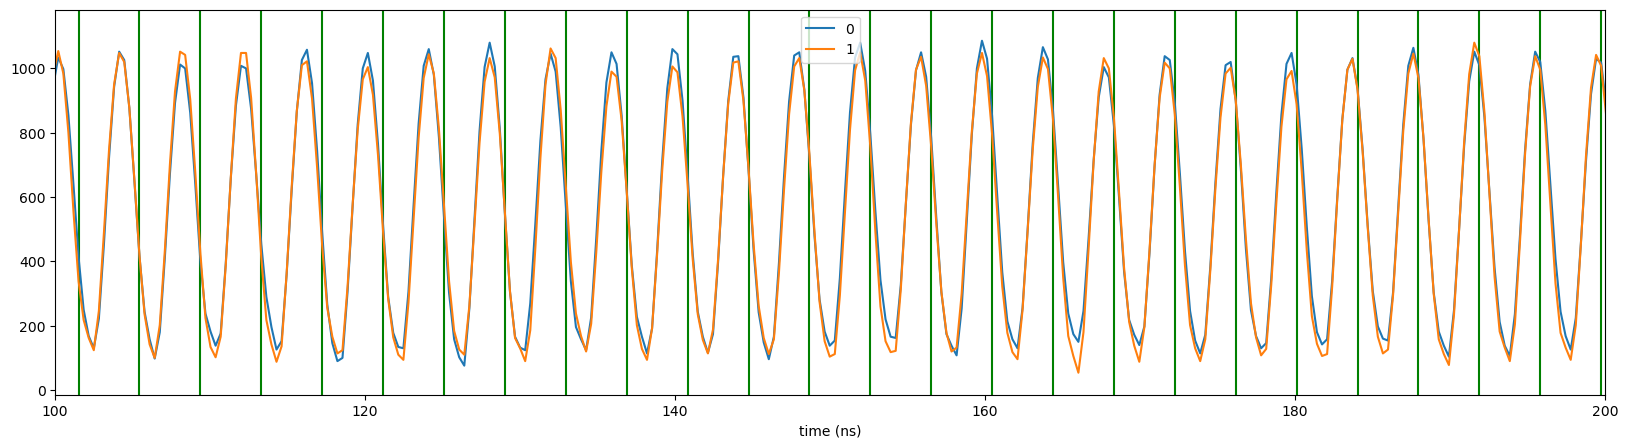

In [20]:
plt.figure(figsize=(20,5))

for x_value in tate:
    plt.axvline(x=x_value,c='g')
plt.plot(t[0],Data[0],label='0')
plt.plot(t[0],Data[1],label='1')
#plt.plot(point,Data[2],label='2')
#plt.plot(point,Data[3],label='3')
plt.xlim(100,200)
plt.xlabel("time (ns)")
plt.legend()
plt.show()

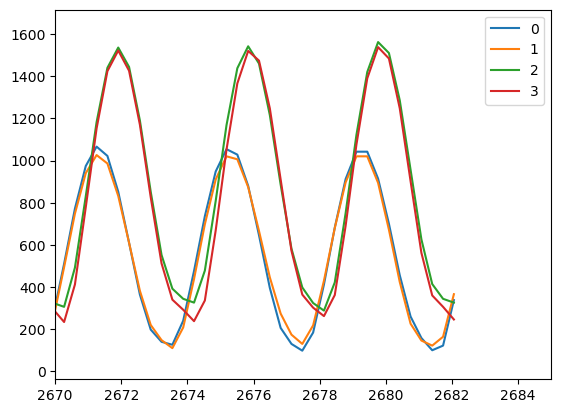

In [8]:
plt.plot(t[0],Data[0],label='0')
plt.plot(t[1],Data[1],label='1')
plt.plot(t[2],Data[2],label='2')
plt.plot(t[3],Data[3],label='3')
plt.xlim(2670,2685)
plt.legend()
plt.show()

In [101]:
def old_peak_search(waveform,threshold):
    mountain_maxima = []
    for i in range(1, len(waveform) - 1):
        if waveform[i] >= waveform[i - 1] and waveform[i] > waveform[i + 1]:
            candidate_peak = waveform[i]
            if candidate_peak > threshold:
                mountain_maxima.append(candidate_peak)
    return np.array(mountain_maxima)

In [130]:
def peak_search(waveform,start_index):
    mountain_maxima = []
    points_per_bunch = 12
    print(start_index)
    for i in range(start_index, len(waveform)-points_per_bunch+start_index, points_per_bunch):
        peak = max(np.array(waveform[i:i+points_per_bunch]))
        if peak >= 500:
            mountain_maxima.append(peak)
        else:
            mountain_maxima.append(0)

    return np.array(mountain_maxima)

4
4
5


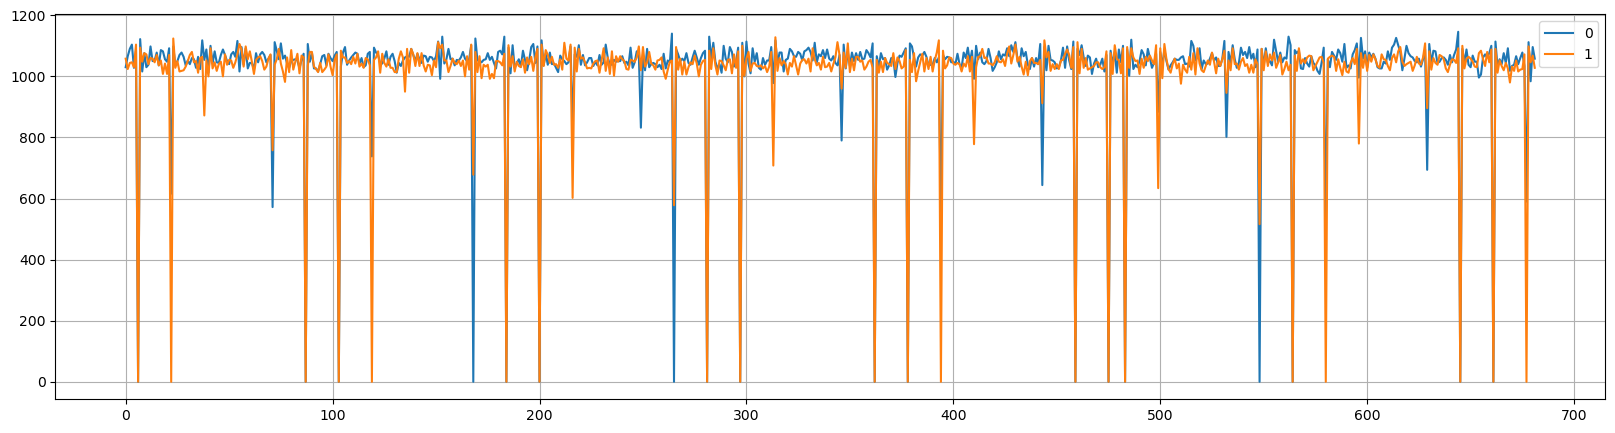

In [131]:
index=np.argmin(Data[0][:12])
length=len(peak_search(waveform=Data[0],start_index=index))
x=np.arange(0,length)
plt.figure(figsize=(20,5))
plt.plot(x,peak_search(waveform=Data[0],start_index=np.argmin(Data[0][:12])),label='0')
plt.plot(x,peak_search(waveform=Data[1],start_index=np.argmin(Data[1][:12])),label='1')
#plt.plot(x,peak_search(waveform=Data[2],start_index=np.argmin(Data[2][:12])),label='2')
#plt.plot(x,peak_search(waveform=Data[3],start_index=np.argmin(Data[3][:12])),label='3')
plt.grid()
plt.legend()